The theory for this notebook is developed in `ZonotopesNonlinearReach`.

In [1]:
# load packages
using Plots
using LazySets, MathematicalSystems, Reachability
using LazySets.Approximations
using Reachability: center
using Reachability.ReachSets: Φ₁
using IntervalArithmetic, ValidatedNumerics
using LazySets: Interval, translate
using TaylorSeries
using TaylorSeries: gradient, jacobian, hessian, derivative
const ∂ = derivative

derivative (generic function with 10 methods)

After loading the packages, you should precompile the functions under the section *auxiliary functions* below.

In [180]:
function vanderpol_ASB08()
    # number of Taylor terms considered in the linearization
    taylor_terms = 4

    # define the working variables and fix the max order in the Taylor series expansion
    x = set_variables("x", numvars=2, order=taylor_terms)

    # define the ODE
    f = Vector{TaylorN{Float64}}(undef, 2)
    f[1] = x[2]
    f[2] = x[2] * (1-x[1]^2) - x[1]

    # define the initial-value problem
    
    𝑋₀ = Hyperrectangle(low=[1.25, 2.35], high=[1.55, 2.45])
    
    𝑋₀ = split(𝑋₀, [4, 4])[1]
    
    𝑆 = BlackBoxContinuousSystem(f, 2)
    𝑃 = InitialValueProblem(𝑆, 𝑋₀)
    𝑂 = Options(:δ => 0.02, :δcont => 0.02/20, :max_order=>2, :θ=>fill(0.05, 2), :taylor_terms=>taylor_terms,
                :T => 7.0, :plot_vars=>[1, 2],
                :opC => "BFFPSV18")
    return 𝑃, 𝑂
end

vanderpol_ASB08 (generic function with 1 method)

In [181]:
@time begin 𝑃, 𝑂 = vanderpol_ASB08() end

  0.247713 seconds (255.06 k allocations: 13.699 MiB, 13.25% gc time)


(InitialValueProblem{BlackBoxContinuousSystem{Array{TaylorN{Float64},1}},Hyperrectangle{Float64}}(BlackBoxContinuousSystem{Array{TaylorN{Float64},1}}(TaylorN{Float64}[ 1.0 x₂ + 𝒪(‖x‖⁵),  - 1.0 x₁ + 1.0 x₂ - 1.0 x₁² x₂ + 𝒪(‖x‖⁵)], 2), Hyperrectangle{Float64}([1.2875, 2.3625], [0.0375, 0.0125])), Options(Dict{Symbol,Any}(:T=>7.0,:δcont=>0.001,:max_order=>2,:opC=>"BFFPSV18",:taylor_terms=>4,:δ=>0.02,:θ=>[0.05, 0.05],:plot_vars=>[1, 2])))

### Algorithm

In [182]:
function post(𝑃::InitialValueProblem{<:BBCS},
              𝑂::Options)

    # get nonlinear ODE
    f = 𝑃.s.f
    
    # unrwap commonly used options
    δ, δcont, θ, T = 𝑂[:δ], 𝑂[:δcont], 𝑂[:θ], 𝑂[:T]
    opC = 𝑂[:opC]

    # general options for the continuous post
    𝑂cont = Options(:T=>δ)

    # algorithm-specific options for the continuous post
    𝑂_GLGM06 = Options(:δ=>𝑂[:δcont], :max_order=>𝑂[:max_order])
    𝑂_BFFPSV18 = Options(:δ=>𝑂[:δcont])
    
    # final result is stored in Rsets
    if opC == "GLGM06"
        Rsets = Vector{ReachSet{Zonotope{Float64}, Float64}}()
    elseif opC == "BFFPSV18" 
        Rsets = Vector{ReachSet{Hyperrectangle{Float64}, Float64}}()
    end

    #times = Vector{Float64}()
    t0 = 0.0 # initial time for each chunk

    # count number of continuous post chunks added to Rsets
    nchunks = 0

    while t0 < T

        # obtain linearized system
        x̃, 𝑃lin = linearize(𝑃, δ)

        # compute flowpipe of the linearized system
        if opC == "GLGM06"
            Rlin = solve(𝑃lin, 𝑂cont, op=GLGM06(𝑂_GLGM06))
        elseif opC == "BFFPSV18"
            Rlin = solve(𝑃lin, 𝑂cont, op=BFFPSV18(𝑂_BFFPSV18))
        end

        # compute set of admissible linearization errors
        R̄err, L̄ = admissible_error(𝑃lin.s.A, δ, θ, n=2)
        L = lagrange_remainder(f, Rlin, R̄err, x̃, n=2)

        if !(L ⊆ L̄)
            println(L)
            println(L̄)
            print("split not implemented")
            return ReachSolution(Rsets, 𝑂)
            #𝑋₀split = split(𝑋₀, (2, 1))
        else
            nchunks += 1
            println("adding chunk $nchunks")
            _add_chunk!(Rsets, Rlin, R̄err, t0)
            𝑃 = IVP(𝑃.s, Rsets[end].X)
            t0 += δ
        end
    end 
    println("total chunks = $nchunks")
    return ReachSolution(Rsets, 𝑂)
end

post (generic function with 1 method)

In [183]:
@time Rsol = post(𝑃, 𝑂);
nsets = length(Rsol.Xk)

adding chunk 1
adding chunk 2
adding chunk 3
adding chunk 4
adding chunk 5
adding chunk 6
adding chunk 7
adding chunk 8
adding chunk 9
adding chunk 10
Hyperrectangle{Float64}([0.0, 0.0], [0.0, 0.0577855])
Hyperrectangle{Float64}([0.0, 0.0], [0.0504927, 0.054077])
split not implemented  0.362734 seconds (201.62 k allocations: 12.587 MiB)


200

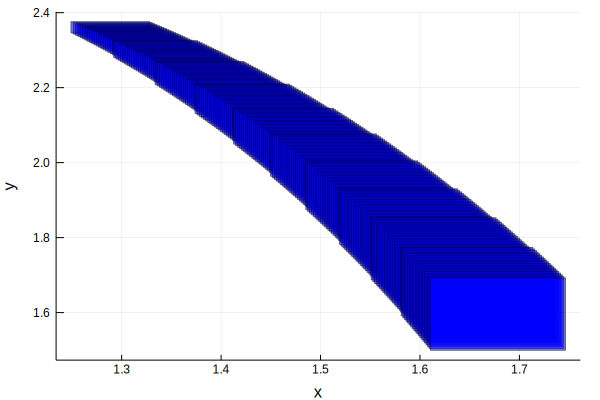

In [184]:
plot([Rsol.Xk[i].X for i in 1:1:nsets], xlab="x", ylab="y", alpha=.5)

### Appendix: auxiliary functions

In [5]:
function linearize(𝑃::IVP{<:BBCS}, δ)

    # nonlinear ODE
    f = 𝑃.s.f
    
    # initial set of current chunk
    𝑋₀i = 𝑃.x0

    # linearization point for current chunk
    c = center(𝑋₀i)
    x̃ = c + δ/2 * f(c)

    # evaluate Jacobian at the linearization point
    Ax̃ = jacobian(f, x̃) #  map(x -> evaluate(x, x̃), Jf)
    bx̃ = f(x̃) - Ax̃ * x̃

    # instantiate linearized system; it doesn't have state constraints
    𝑆lin = ConstrainedAffineContinuousSystem(Ax̃, bx̃, Universe(2));
    𝑃lin = IVP(𝑆lin, 𝑋₀i)
    return x̃, 𝑃lin
end

linearize (generic function with 1 method)

In [63]:
function _add_chunk!(Rsets::Vector{ReachSet{Hyperrectangle{Float64}, Float64}}, Rlin, R̄err, t0)
    #println("using hyperrect")
    @inbounds for i in eachindex(Rlin.Xk)
        Ri = Rlin.Xk[i].X ⊕ R̄err
        Ri = overapproximate(Ri, Hyperrectangle)
        Ri = ReachSet(Ri, t0 + Rlin.Xk[i].t_start, t0 + Rlin.Xk[i].t_end)
        push!(Rsets, Ri)
    end
    return Rsets
end

function _add_chunk!(Rsets::Vector{ReachSet{Zonotope{Float64}, Float64}}, Rlin, R̄err, t0)
    #println("using zonotopes")
    @inbounds for i in eachindex(Rlin.Xk)
        Ri = minkowski_sum(Rlin.Xk[i].X, convert(Zonotope, R̄err))
        Ri = ReachSet(Ri, t0 + Rlin.Xk[i].t_start, t0 + Rlin.Xk[i].t_end)
        push!(Rsets, Ri)
    end
    return Rsets
end

_add_chunk! (generic function with 2 methods)

In [7]:
function admissible_error(Ax̃, δ, θ; n=2)
    @assert n == 2
    Φ₁_Aδ = Φ₁(Ax̃, δ)
    R̄err = Hyperrectangle(zeros(2), θ*δ)
    l̄ = abs.(inv(Φ₁_Aδ)) * θ * δ
    L̄ = Hyperrectangle(zeros(2), l̄)
    return R̄err, L̄
end

admissible_error (generic function with 1 method)

In [8]:
function lagrange_remainder(f, Rlin, R̄err, x̃; n=2)
    @assert n == 2
    
    Hf₁ = [∂(f[1], (2, 0)) ∂(f[1], (1, 1));
           ∂(f[1], (1, 1)) ∂(f[1], (0, 2))]
    Hf₂ = [∂(f[2], (2, 0)) ∂(f[2], (1, 1));
           ∂(f[2], (1, 1)) ∂(f[2], (0, 2))]

    R̂lin = ConvexHullArray([Ri.X for Ri in Rlin.Xk]) ⊕ R̄err
    R̂lin_rect = overapproximate(R̂lin, Hyperrectangle)

    ξ = CH(Singleton(x̃), R̂lin_rect)
    ξ_rect = overapproximate(ξ, Hyperrectangle)
    ξ_box = convert(IntervalBox, ξ_rect)

    Hf₁_box = map(Hf_ij -> evaluate(Hf_ij, ξ_box), Hf₁)
    Hf₂_box = map(Hf_ij -> evaluate(Hf_ij, ξ_box), Hf₂)

    R̂lin_zono = convert(Zonotope, R̂lin_rect)

    γ = abs.(R̂lin_zono.center - x̃) + sum(abs.(R̂lin_zono.generators), dims=2)
    
    G = [sup.(abs.(Hf₁_box)), sup.(abs.(Hf₂_box))];
    li_zono = [(1/2 * transpose(γ) * G[i] * γ)[1, 1] for i in 1:n]
    L = Hyperrectangle(zeros(n), li_zono)
    return L
end

lagrange_remainder (generic function with 1 method)

### Other scripts

In [9]:
#=
@time begin
# number of Taylor terms considered in the linearization
taylor_terms = 4

# define the working variables and fix the max order in the Taylor series expansion
x = set_variables("x", numvars=2, order=taylor_terms)

# define the ODE
f = Vector{TaylorN{Float64}}(undef, 2)
f[1] = x[2]
f[2] = x[2] * (1-x[1]^2) - x[1]

# define the initial-value problem
𝑋₀ = Hyperrectangle(low=[1.25, 2.35], high=[1.55, 2.45])
𝑆 = BlackBoxContinuousSystem(f, 2)
𝑃 = InitialValueProblem(𝑆, 𝑋₀)

# take the gradient of the vector field symbolically
#∇f = [gradient(f[i]) for i in 1:2]

# take the Jacobian matrix of the vector field symbolically
#Jf = [∂(f[1], (1, 0)) ∂(f[1], (0, 1));
#      ∂(f[2], (1, 0)) ∂(f[2], (0, 1))]

# algorithm-specific options
𝑂 = Options(:δ => 0.02, :δcont => 0.02/10, :max_order=>2, :θ=>fill(0.05, 2))

# unwrap options
δ = O[:δ]
θ = O[:θ]

# collection of flowpipes; the set type depends on add_chunk! and the continuous post
Rsets = Vector{ReachSet{Hyperrectangle{Float64}, Float64}}()
end
=#

In [ ]:
#=
@time begin
x̃, 𝑃lin = linearize(𝑃, δ)
end;
𝑋₀i = 𝑃lin.x0

# use zonotope-based continuous reach
@time begin
Rlin_zono = solve(𝑃lin, Options(:T=>O[:δ]), op=GLGM06(:δ=>O[:δcont], :max_order=>O[:max_order]))
end;

# use decomposition-based continuous reach
@time begin
Rlin_box = solve(𝑃lin, Options(:T=>O[:δ]), op=BFFPSV18(:δ=>O[:δcont]))
end;

plot(Rlin_zono, alpha=.5)
plot!(Rlin_box, alpha=.5, xlab="x", ylab="y")

Rlin = Rlin_zono  # decide which continuoust post to use

@time begin
R̄err, L̄ = admissible_error(𝑃lin.s.A, δ, θ; n=2)
L = lagrange_remainder(f, Rlin, R̄err, x̃; n=2)
end
=#